In [1]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import segmentation_models_pytorch as smp
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 896.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6a6446ec46320482349ed833647e98611220b9f190e63a5f688c21e6e49ad1db
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=053cc31030a04ab2a252012aab2fcc5b38df379cee3b3034ce39e1bbb28389e3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [2]:
#Let's seed everything to make results somewhat reproducible

def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
int(len(os.listdir('../input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/images'))*0.8)

2133

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, input_dir, output_dir, is_train, transform=None):
        self.input_dir  = input_dir
        self.output_dir = output_dir
        self.transform  = transform
        if is_train == True : self.images = os.listdir(input_dir)[:int(len(os.listdir(input_dir))*0.8)]
        else                : self.images = os.listdir(input_dir)[int(len(os.listdir(input_dir))*0.8):]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path    = os.path.join(self.input_dir, self.images[index])
        mask_path   = os.path.join(self.output_dir, self.images[index])
        img         = np.array(Image.open(img_path).convert("RGB"), dtype=np.float32) / 255
        mask        = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)   / 255
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img   = augmentations["image"]
            mask  = augmentations["mask"]
        
        return img, mask

In [5]:
TRAIN_INP_DIR = '../input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/images/'
TRAIN_OUT_DIR = '../input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/masks/'
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

LEARNING_RATE = 3e-4
BATCH_SIZE    = 64
NUM_EPOCHS    = 10
IMAGE_HEIGHT  = 256  
IMAGE_WIDTH   = 192  

train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.ColorJitter(p=0.2),
        A.HorizontalFlip(p=0.5),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        ToTensorV2(),
    ],
)
def get_loaders( inp_dir, mask_dir,batch_size,
			     train_transform, val_tranform ):
    
    train_ds     = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=True, transform=train_transform)

    train_loader = DataLoader( train_ds, batch_size=batch_size, shuffle=True )

    val_ds       = SegmentationDataset( input_dir=inp_dir, output_dir=mask_dir,
                            is_train=False, transform=val_transform)

    val_loader   = DataLoader( val_ds, batch_size=batch_size, shuffle=True  )

    return train_loader, val_loader

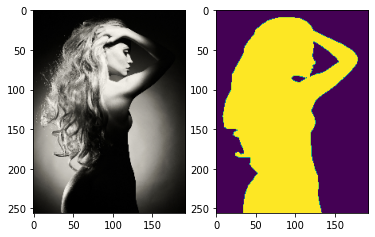

In [6]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR,
                            BATCH_SIZE,  train_transform, val_transform)
inputs, masks = next(iter(train_loader))

_, ax = plt.subplots(1,2)
ax[0].imshow(inputs[0].permute(1,2,0))
ax[1].imshow(masks[0])

In [7]:
################################## Utils
def save_checkpoint(state, filename): 
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels  = 0
    dice_score  = 0
    model.eval()

    with torch.no_grad():
        for img, mask in tqdm(loader):
            img   = img.to(device)
            mask  = mask.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(img))
            preds = (preds > 0.5).float()
            num_correct += (preds == mask).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * mask).sum()) / (
                (preds + mask).sum() + 1e-7
            )

    print(
        f"Got {num_correct}/{num_pixels} with pixel accuracy {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)*100:.2f}")
    model.train()

In [8]:
model = smp.Unet(encoder_name='efficientnet-b3',
     in_channels=3, classes=1, activation=None).to(DEVICE)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

In [9]:
def train_fn(loader, model, optimizer, loss_fn):
    loop = tqdm(loader)

    for batch_idx, (image, mask) in enumerate(loop):
        image   = image.to(device=DEVICE)
        mask    = mask.float().unsqueeze(1).to(device=DEVICE)

        # forward
        predictions = model(image)
        loss = loss_fn(predictions, mask)

        # backward
        model.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [10]:
check_accuracy(val_loader, model, device=DEVICE)

for epoch in range(NUM_EPOCHS):

    print('########################## epoch: '+str(epoch))
    train_fn(train_loader, model, optimizer, loss_fn)
    
    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

100%|██████████| 9/9 [01:00<00:00,  6.77s/it]


Got 8756613/26247168 with pixel accuracy 33.36
Dice score: 47.41
########################## epoch: 0


100%|██████████| 9/9 [00:43<00:00,  4.88s/it]


Got 24171987/26247168 with pixel accuracy 92.09
Dice score: 86.78
########################## epoch: 1


100%|██████████| 9/9 [00:43<00:00,  4.85s/it]


Got 24839324/26247168 with pixel accuracy 94.64
Dice score: 91.78
########################## epoch: 2


100%|██████████| 9/9 [00:43<00:00,  4.86s/it]


Got 25136870/26247168 with pixel accuracy 95.77
Dice score: 93.28
########################## epoch: 3


100%|██████████| 9/9 [00:43<00:00,  4.81s/it]


Got 25249480/26247168 with pixel accuracy 96.20
Dice score: 93.93
########################## epoch: 4


100%|██████████| 9/9 [00:43<00:00,  4.81s/it]


Got 25390684/26247168 with pixel accuracy 96.74
Dice score: 95.06
########################## epoch: 5


100%|██████████| 9/9 [00:43<00:00,  4.87s/it]


Got 25394407/26247168 with pixel accuracy 96.75
Dice score: 95.06
########################## epoch: 6


100%|██████████| 9/9 [00:43<00:00,  4.86s/it]


Got 25415586/26247168 with pixel accuracy 96.83
Dice score: 94.98
########################## epoch: 7


100%|██████████| 9/9 [00:43<00:00,  4.80s/it]


Got 25478603/26247168 with pixel accuracy 97.07
Dice score: 95.48
########################## epoch: 8


100%|██████████| 9/9 [00:43<00:00,  4.83s/it]


Got 25502567/26247168 with pixel accuracy 97.16
Dice score: 95.77
########################## epoch: 9


100%|██████████| 9/9 [00:43<00:00,  4.84s/it]

Got 25551450/26247168 with pixel accuracy 97.35
Dice score: 95.71


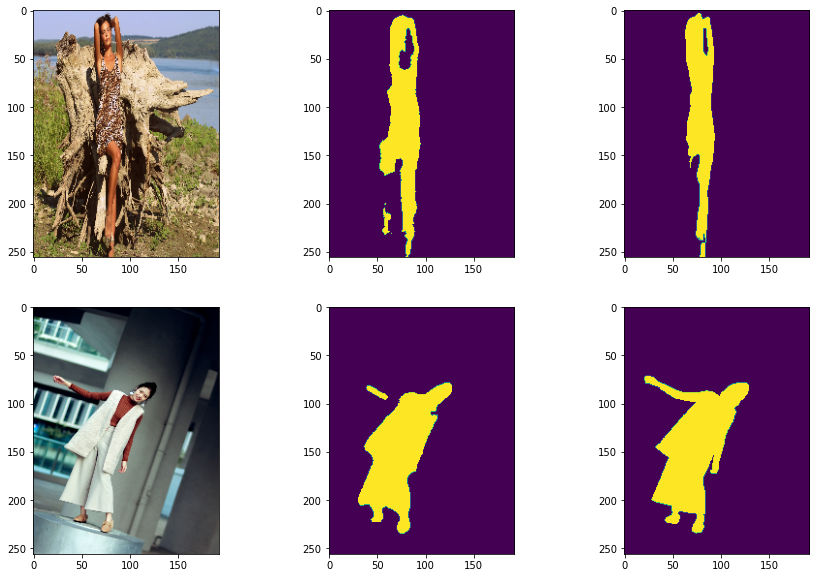

In [11]:
train_loader, val_loader = get_loaders( TRAIN_INP_DIR, TRAIN_OUT_DIR,
                            BATCH_SIZE,  train_transform, val_transform)
inputs, masks = next(iter(val_loader))
output        = ((torch.sigmoid(model(inputs.to('cuda')))) >0.5).float()
_, ax = plt.subplots(2,3, figsize=(15,10))
for k in range(2):
    ax[k][0].imshow(inputs[k].permute(1,2,0))
    ax[k][1].imshow(output[k][0].cpu())
    ax[k][2].imshow(masks[k])